<!-- Diabete prediction | EDA - Optuna - Features - Ensemble -->
<a id="0"></a>
<div style="font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#FF6B6B; font-size:300%; text-align:left; padding:3.0px; background: #2B303A; border-bottom: 8px solid #36454F">
    Diabete prediction | EDA - Optuna - Features - Ensemble<br>
</div>

<img src="https://i.imgur.com/Z9nS1mH.jpg" width="500px">

Photo de <a href="https://unsplash.com/fr/@mykjohnson?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Mykenzie Johnson</a> sur <a href="https://unsplash.com/fr/photos/smartphone-noir-a-cote-dune-bouteille-en-plastique-blanche-et-dun-smartphone-noir-4qjxCUOc3iQ?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Unsplash</a>

# Introduction


##  Dataset Description

- **Objective**: Predict the onset of diabetes based on diagnostic measurements.
- **Demographics**: All patients are Pima Indian females aged 21 or older.
- **Features**: Medical predictor variables include number of pregnancies, BMI, insulin level, age, among others.
- **Target Variable**: Indicates whether the patient has diabetes (Outcome).
- **Context**: Dataset originates from the National Institute of Diabetes and Digestive and Kidney Diseases.

## Evaluation Metric

- **Metric**: We will use **ROC AUC (Receiver Operating Characteristic - Area Under the Curve)** as the evaluation metric.
- **Purpose**: ROC AUC is ideal for evaluating the performance of a binary classification model.
- **Interpretation**: The metric quantifies the model's ability to distinguish between patients with and without diabetes.
- **Probability Prediction**: It measures how well the predicted probabilities of diabetes correspond to the true outcomes.
- **Reasoning**: Using ROC AUC helps ensure that the model's predictions are reliable across different thresholds.

In [1]:
!pip install autogluon.tabular  > /dev/null 2>&1
!pip install -U ipywidgets  > /dev/null 2>&1
!pip install sweetviz > /dev/null 2>&1
!pip install optuna-integration[sklearn] > /dev/null 2>&1
!pip install langchain-core > /dev/null 2>&1
!pip install langchain-openai  > /dev/null 2>&1
!pip install catboost > /dev/null 2>&1

In [5]:
# Import libraries

# LLM Libraries
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# General Purpose Libraries
import json
import logging
import numpy as np
import pandas as pd
import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
import warnings
from IPython.display import Markdown, display
#from kaggle_secrets import UserSecretsClient
from scipy.stats import ttest_ind, stats

# Scikit-Learn Utilities
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, RobustScaler,
                                   PolynomialFeatures, KBinsDiscretizer)
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     cross_val_score, RandomizedSearchCV)

# Scikit-Learn Classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, VotingClassifier)

# External Libraries Classifiers
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, log_evaluation

# Metrics and Scoring
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, make_scorer, roc_auc_score, 
                             confusion_matrix, ConfusionMatrixDisplay)

# Feature Engineering
from featuretools import dfs, EntitySet

# Optuna for Hyperparameter Tuning
import optuna
from optuna.integration import OptunaSearchCV

# AutoML
from autogluon.tabular import TabularPredictor

# SHAP for Explainability
import shap

# Secrets Management
#user_secrets = UserSecretsClient()
#OPENAI_API_KEY = user_secrets.get_secret("openai_key")

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [40]:
N_TRIALS = 50
TIME_LIMIT = 3600 * 4

In [7]:
# Function to classify columns into continuous and categorical
def classify_columns(df):
    continuous_cols = []
    categorical_cols = []
    for column in df.columns:
        if df[column].dtypes == 'object':
            categorical_cols.append(column)
        else:
            unique_values = df[column].nunique()
            if unique_values < 15:
                categorical_cols.append(column)
            else:
                continuous_cols.append(column)
    return continuous_cols, categorical_cols

# Function to perform basic visualizations for continuous and categorical features
def eda_visualizations(df, target=None):
    continuous_cols, categorical_cols = classify_columns(df)
    
    # Plotting continuous columns
    for col in continuous_cols:
        plt.figure(figsize=(10, 4))
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
    
    # Plotting categorical columns
    for col in categorical_cols:
        plt.figure(figsize=(10, 4))
        sns.countplot(data=df, x=col, hue=target)
        plt.title(f'Count plot for {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

# Function to compare train and test datasets
def compare_train_test(train, test):
    continuous_cols, categorical_cols = classify_columns(train)
    
    # Compare continuous columns
    for col in continuous_cols:
        plt.figure(figsize=(10, 4))
        sns.kdeplot(train[col], label='Train', shade=True)
        sns.kdeplot(test[col], label='Test', shade=True)
        plt.title(f'Comparison of {col} Distribution in Train vs Test')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    
    # Compare categorical columns
    for col in categorical_cols:
        if col in test.columns:  # Ensure the column exists in the test dataset
            plt.figure(figsize=(10, 4))
            train_counts = train[col].value_counts(normalize=True)
            test_counts = test[col].value_counts(normalize=True)
            train_counts.plot(kind='bar', alpha=0.5, label='Train', color='blue')
            test_counts.plot(kind='bar', alpha=0.5, label='Test', color='red')
            plt.title(f'Comparison of {col} Proportions in Train vs Test')
            plt.xlabel(col)
            plt.ylabel('Proportion')
            plt.legend()
            plt.xticks(rotation=45)
            plt.show()
            
# Function to create key statistics for a dataset
def eda_summary(df):
    summary = {}
    
    # General Info
    summary['general'] = {
        'num_rows': df.shape[0],
        'num_columns': df.shape[1],
        'num_missing_values': df.isnull().sum().sum(),
        'percent_missing_values': df.isnull().mean().mean() * 100
    }
    
    # Column Data Types
    summary['data_types'] = df.dtypes.to_dict()
    
    # Missing Value Summary (per column)
    summary['missing_values'] = (
        df.isnull()
        .sum()
        .to_frame(name='missing_count')
        .assign(percent_missing=lambda x: (x['missing_count'] / df.shape[0]) * 100)
        .to_dict(orient='index')
    )
    
    # Numerical Summary (Mean, Median, Std, Min, Max)
    describe_df = df.describe()
    numerical_columns = ['mean', '50%', 'std', 'min', 'max']
    available_columns = [col for col in numerical_columns if col in describe_df.columns]
    summary['numerical_summary'] = (
        describe_df[available_columns]
        .rename(columns={'50%': 'median'})
        .to_dict(orient='index')
    )
    
    # Unique Counts for Categorical Columns
    summary['categorical_summary'] = (
        df.select_dtypes(include=['object', 'category'])
        .nunique()
        .to_frame(name='unique_counts')
        .to_dict(orient='index')
    )
    
    # Skewness and Kurtosis
    summary['skewness_kurtosis'] = {
        column: {
            'skewness': df[column].skew(),
            'kurtosis': df[column].kurt()
        } for column in df.select_dtypes(include=[np.number]).columns
    }
    
    # Correlations
    try:
        summary['correlations'] = df.corr(numeric_only=True).to_dict()
    except ValueError:
        summary['correlations'] = "Unable to calculate correlations due to data type issues."
    
    # Outlier Count based on IQR
    outlier_summary = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
        outlier_summary[column] = {
            'outlier_count': outliers.shape[0],
            'percent_outliers': (outliers.shape[0] / df.shape[0]) * 100
        }
    summary['outlier_summary'] = outlier_summary

    return summary

# Automated EDA

In [6]:
data = pd.read_csv('diabetes.csv')

In [8]:
# Basic Exploration
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [9]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [10]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [13]:
# Automated EDA report with sweetviz
report = sv.analyze(data, pairwise_analysis="off")
report.show_html(filepath='./AutoML/report/data_report.html', open_browser=False)

                                             |          | [  0%]   00:00 -> (? left)

Report ./AutoML/report/data_report.html was generated.


In [14]:
summary = eda_summary(data)

# Convert summary to JSON format
summary_json = json.dumps(summary, indent=4, default=str)

In [16]:
# Define the prompt template for LangChain
template = """Provide an analysis of the following EDA summary:
{context}

Key insights and observations:
"""

prompt = ChatPromptTemplate.from_template(template)

# Define the LLM model using LangChain
model = ChatOpenAI(
    model='gpt-4o-2024-05-13',
    temperature=0
    #api_key=OPENAI_API_KEY
)

# Create a chain to pass the summary to the model
chain = prompt | model | StrOutputParser()

# Invoke the chain to analyze the EDA summary
result = chain.invoke(summary_json)

# Print the result
display(Markdown(result))

The provided Exploratory Data Analysis (EDA) summary offers a comprehensive overview of a dataset with 768 rows and 9 columns. Here are the key insights and observations:

### General Overview
- **Number of Rows and Columns**: The dataset contains 768 rows and 9 columns.
- **Missing Values**: There are no missing values in the dataset, which is excellent for analysis as it eliminates the need for imputation or data cleaning related to missing values.

### Data Types
- The dataset consists of both integer (`int64`) and float (`float64`) data types:
  - **Integer Columns**: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, Age, Outcome.
  - **Float Columns**: BMI, DiabetesPedigreeFunction.

### Missing Values
- As mentioned, there are no missing values in any of the columns, which simplifies the preprocessing steps.

### Skewness and Kurtosis
- **Pregnancies**: Positively skewed (0.90) with a slight kurtosis (0.16).
- **Glucose**: Slightly positively skewed (0.17) with moderate kurtosis (0.64).
- **BloodPressure**: Highly negatively skewed (-1.84) with high kurtosis (5.18), indicating a heavy tail.
- **SkinThickness**: Nearly symmetric (0.11) with slight negative kurtosis (-0.52).
- **Insulin**: Highly positively skewed (2.27) with high kurtosis (7.21), indicating a heavy tail.
- **BMI**: Slightly negatively skewed (-0.43) with moderate kurtosis (3.29).
- **DiabetesPedigreeFunction**: Highly positively skewed (1.92) with high kurtosis (5.59).
- **Age**: Positively skewed (1.13) with moderate kurtosis (0.64).
- **Outcome**: Positively skewed (0.64) with negative kurtosis (-1.60).

### Correlations
- **Outcome**: 
  - Strongest positive correlation with Glucose (0.47), followed by BMI (0.29), Age (0.24), and Pregnancies (0.22).
  - Weak correlations with other variables.
- **Pregnancies**: 
  - Strong positive correlation with Age (0.54).
- **Glucose**: 
  - Moderate positive correlations with Insulin (0.33), Age (0.26), and BMI (0.22).
- **BloodPressure**: 
  - Moderate positive correlation with BMI (0.28).
- **SkinThickness**: 
  - Moderate positive correlations with Insulin (0.44) and BMI (0.39).
- **Insulin**: 
  - Moderate positive correlation with SkinThickness (0.44).
- **BMI**: 
  - Moderate positive correlation with SkinThickness (0.39).

### Outlier Summary
- **BloodPressure**: Highest number of outliers (45), constituting 5.86% of the data.
- **Insulin**: Significant number of outliers (34), constituting 4.43% of the data.
- **DiabetesPedigreeFunction**: 29 outliers (3.78%).
- **BMI**: 19 outliers (2.47%).
- **Age**: 9 outliers (1.17%).
- **Pregnancies**: 4 outliers (0.52%).
- **Glucose**: 5 outliers (0.65%).
- **SkinThickness**: 1 outlier (0.13%).
- **Outcome**: No outliers.

### Key Insights
1. **No Missing Data**: The dataset is complete with no missing values, which is advantageous for analysis.
2. **Skewness and Kurtosis**: Several variables exhibit significant skewness and kurtosis, indicating potential non-normal distributions. This is particularly notable for Insulin, BloodPressure, and DiabetesPedigreeFunction.
3. **Correlations**: 
   - Glucose has the strongest correlation with the Outcome, suggesting it might be a key predictor for diabetes.
   - Age and BMI also show moderate correlations with the Outcome.
4. **Outliers**: 
   - BloodPressure and Insulin have a high number of outliers, which may need to be addressed through techniques like transformation or robust statistical methods.
   - The presence of outliers in several variables suggests the need for careful handling during modeling to avoid skewed results.

### Recommendations
- **Data Transformation**: Consider transforming highly skewed variables to normalize their distributions.
- **Outlier Treatment**: Investigate and potentially treat outliers, especially in BloodPressure and Insulin, to improve model performance.
- **Feature Engineering**: Given the correlations, consider creating interaction terms or polynomial features for Glucose, BMI, and Age to capture non-linear relationships.
- **Modeling**: Use models robust to outliers or apply techniques like regularization to mitigate their impact.

This EDA summary provides a solid foundation for further analysis and model building.

In [18]:
# Define the prompt template for LangChain
template_features = """Provide an analysis of the following EDA summary and offer advice on feature engineering to improve predictions of loan approvals:
{context}

Feature Engineering Recommendations for tree-based models:
"""

prompt = ChatPromptTemplate.from_template(template_features)
chain = prompt | model | StrOutputParser()
result = chain.invoke(summary_json)
display(Markdown(result))

Based on the provided Exploratory Data Analysis (EDA) summary, here are some feature engineering recommendations to improve predictions of loan approvals using tree-based models:

### 1. Handling Skewness and Outliers
Tree-based models are generally robust to outliers, but handling extreme skewness can still improve model performance.

- **Log Transformation**: Apply log transformation to highly skewed features such as `Insulin`, `DiabetesPedigreeFunction`, and `Age`. This can help in reducing the impact of extreme values.
  ```python
  import numpy as np
  df['Insulin_log'] = np.log1p(df['Insulin'])
  df['DiabetesPedigreeFunction_log'] = np.log1p(df['DiabetesPedigreeFunction'])
  df['Age_log'] = np.log1p(df['Age'])
  ```

### 2. Feature Interactions
Creating interaction features can help tree-based models capture complex relationships between variables.

- **Polynomial Features**: Create polynomial features for `Glucose`, `BMI`, and `Age` as they have relatively higher correlations with the target variable `Outcome`.
  ```python
  from sklearn.preprocessing import PolynomialFeatures
  poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
  poly_features = poly.fit_transform(df[['Glucose', 'BMI', 'Age']])
  poly_feature_names = poly.get_feature_names(['Glucose', 'BMI', 'Age'])
  df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)
  df = pd.concat([df, df_poly], axis=1)
  ```

### 3. Binning Continuous Variables
Binning can help in reducing the noise and capturing non-linear relationships.

- **Age Binning**: Create age bins to capture age-related patterns.
  ```python
  df['Age_bin'] = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60, 70, 80], labels=False)
  ```

### 4. Aggregating Features
Aggregating features can help in summarizing the data and reducing dimensionality.

- **Mean and Standard Deviation**: Calculate the mean and standard deviation of `Glucose`, `BloodPressure`, `BMI`, and `Insulin`.
  ```python
  df['mean_glucose_bmi'] = df[['Glucose', 'BMI']].mean(axis=1)
  df['std_glucose_bmi'] = df[['Glucose', 'BMI']].std(axis=1)
  ```

### 5. Encoding Categorical Variables
Although the dataset does not contain categorical variables, if there were any, encoding them properly would be crucial.

- **One-Hot Encoding**: For any categorical variables, use one-hot encoding.
  ```python
  df = pd.get_dummies(df, columns=['categorical_column'])
  ```

### 6. Feature Scaling
Tree-based models do not require feature scaling, but it can still be beneficial for interpretability and other preprocessing steps.

- **Standard Scaling**: Apply standard scaling to continuous features.
  ```python
  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()
  df[['Glucose', 'BloodPressure', 'BMI', 'Insulin']] = scaler.fit_transform(df[['Glucose', 'BloodPressure', 'BMI', 'Insulin']])
  ```

### 7. Feature Selection
Select features based on their importance and correlation with the target variable.

- **Correlation Threshold**: Remove features with low correlation to the target variable.
  ```python
  correlation_threshold = 0.1
  correlated_features = df.corr()['Outcome'].abs()
  selected_features = correlated_features[correlated_features > correlation_threshold].index
  df = df[selected_features]
  ```

### 8. Synthetic Features
Create synthetic features that might capture additional information.

- **Health Risk Score**: Create a synthetic feature that combines `BMI`, `Glucose`, and `BloodPressure` to represent a health risk score.
  ```python
  df['health_risk_score'] = df['BMI'] * df['Glucose'] / df['BloodPressure']
  ```

### Summary
By applying these feature engineering techniques, you can enhance the predictive power of your tree-based models. The key is to experiment with different combinations and transformations to find the optimal set of features for your specific problem.

# Detailled EDA

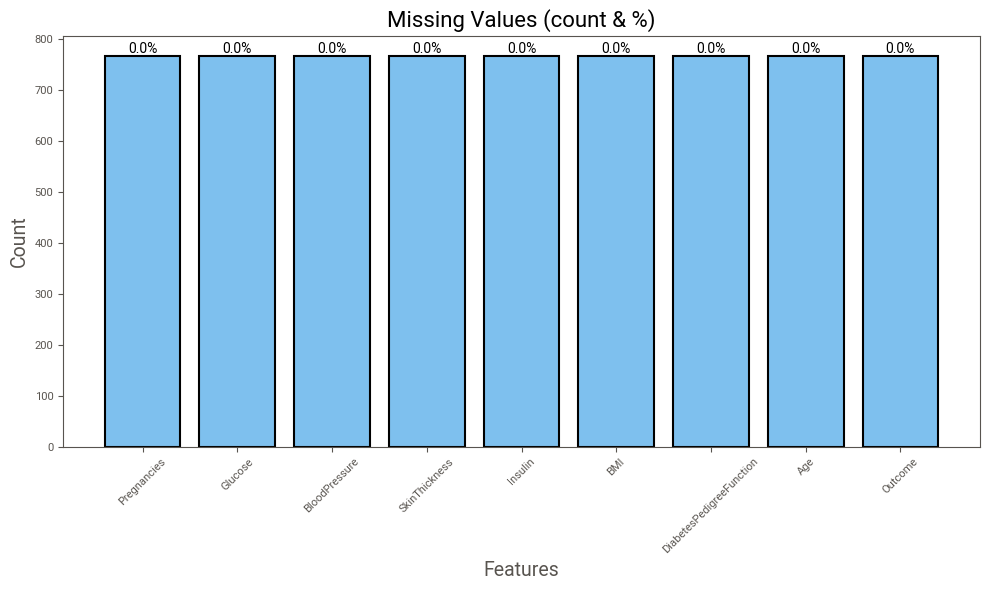

In [19]:
# Define missing plot function to detect all missing values in dataset
def missing_plot(dataset, key):
    # Count of non-null values
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns=['Count'])
    # Percentage of missing values
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum())) / len(dataset[key]) * 100, columns=['Count'])
    percentage_null = percentage_null.round(2)

    # Plotting using matplotlib
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(null_feat.index, null_feat['Count'], color='#7EC0EE', edgecolor='#000000', linewidth=1.5)

    # Adding percentage values on top of bars
    for bar, percentage in zip(bars, percentage_null['Count']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'{percentage}%', ha='center', va='bottom', fontsize=10)

    # Set title and labels
    ax.set_title("Missing Values (count & %)", fontsize=16)
    ax.set_xlabel("Features", fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Plotting
missing_plot(data, 'Outcome')

In [20]:
# Define count plot function for the 'Outcome' variable
def target_count(dataset):
    outcome_counts = dataset['Outcome'].value_counts()
    labels = ['Healthy', 'Diabetic']

    # Plotting using matplotlib
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.barh(labels, outcome_counts.values, color=['#0072B2', '#D55E00'], edgecolor='#000000', linewidth=1.5)

    # Adding count values on bars
    for bar, count in zip(bars, outcome_counts.values):
        width = bar.get_width()
        ax.text(width + 0.1, bar.get_y() + bar.get_height() / 2, f'{count}', ha='center', va='center', fontsize=12)

    # Set title and labels
    ax.set_title('Count of Outcome Variable', fontsize=16)
    ax.set_xlabel('Count', fontsize=14)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Define percentage plot function for the 'Outcome' variable
def target_percent(dataset):
    outcome_counts = dataset['Outcome'].value_counts()
    labels = ['Healthy', 'Diabetic']

    # Plotting using matplotlib
    fig, ax = plt.subplots(figsize=(8, 8))
    wedges, texts, autotexts = ax.pie(outcome_counts.values, labels=labels, autopct='%1.1f%%', 
                                      colors=['#0072B2', '#D55E00'], textprops={'fontsize': 12}, 
                                      wedgeprops={'edgecolor': '#000000', 'linewidth': 1.5})

    # Set title
    ax.set_title('Distribution of Outcome Variable', fontsize=16)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

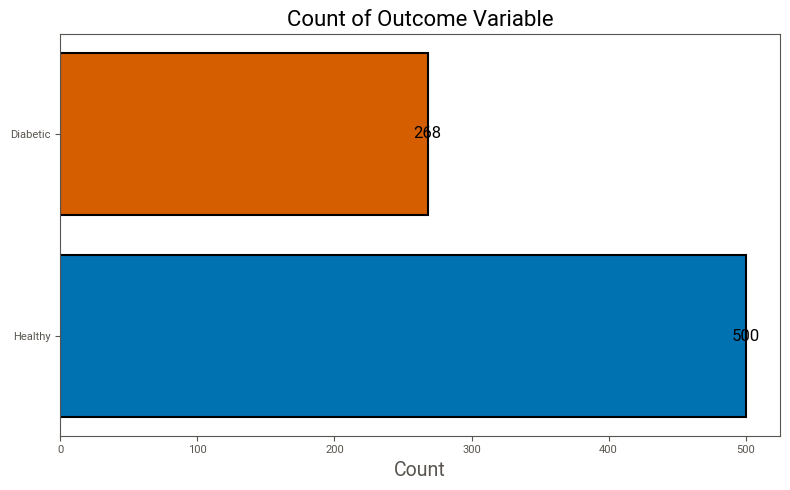

In [21]:
target_count(data)

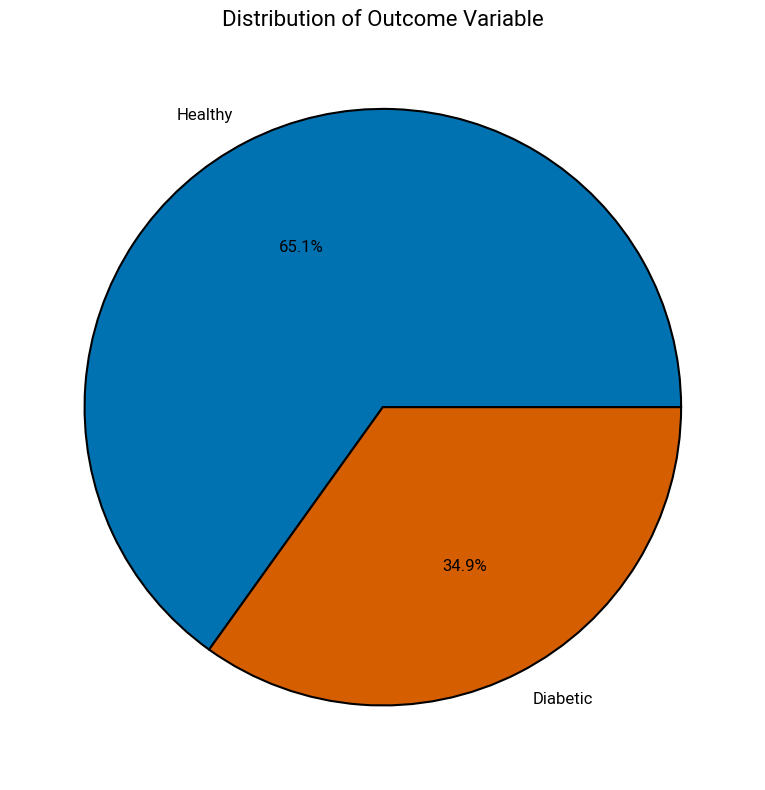

In [22]:
target_percent(data)

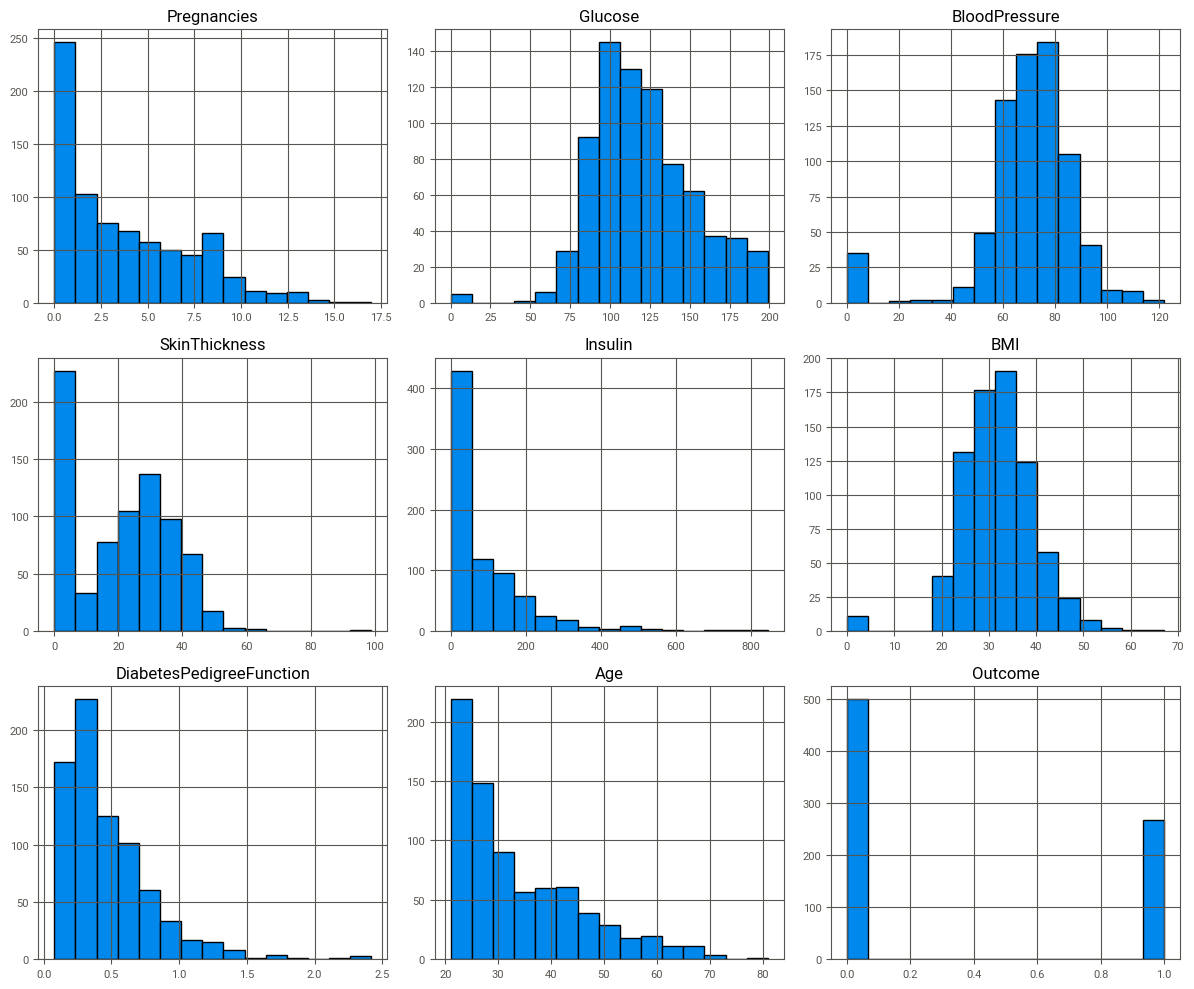

In [23]:
# Plot histograms for all features
data.hist(figsize=(12, 10), bins=15, edgecolor='black')
plt.tight_layout()
plt.show()

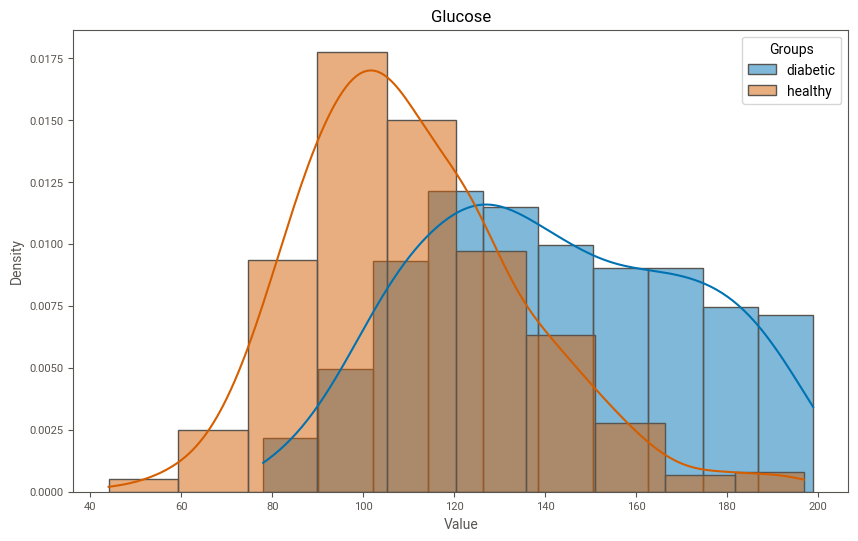

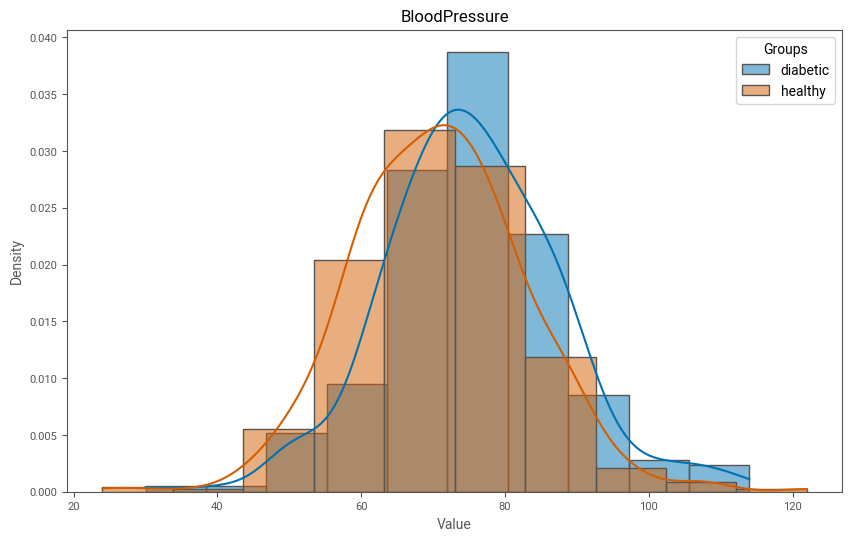

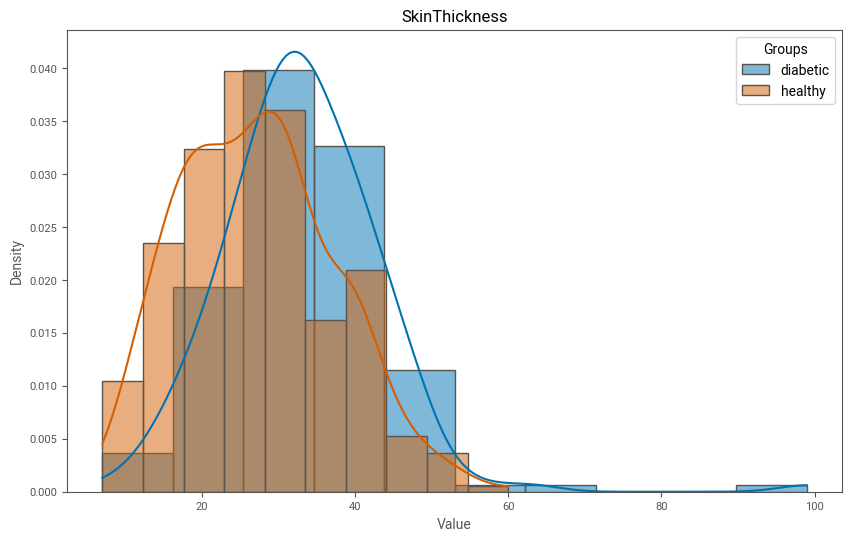

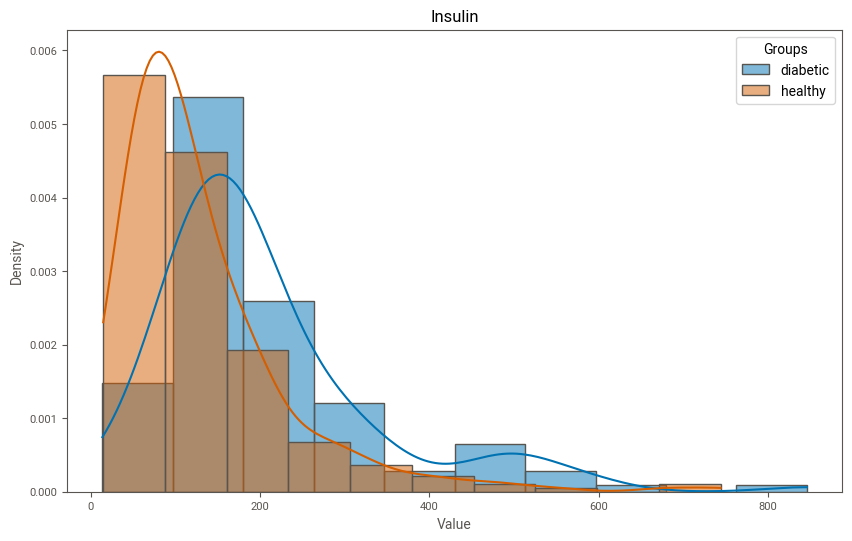

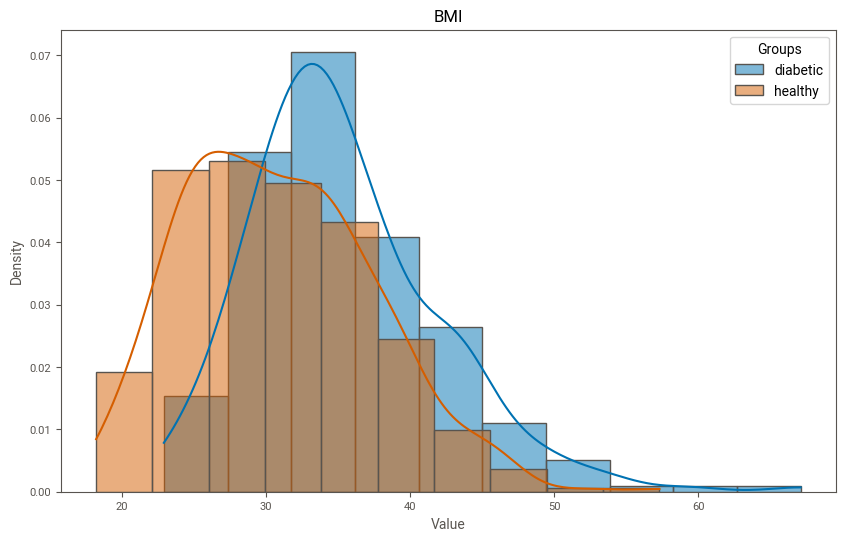

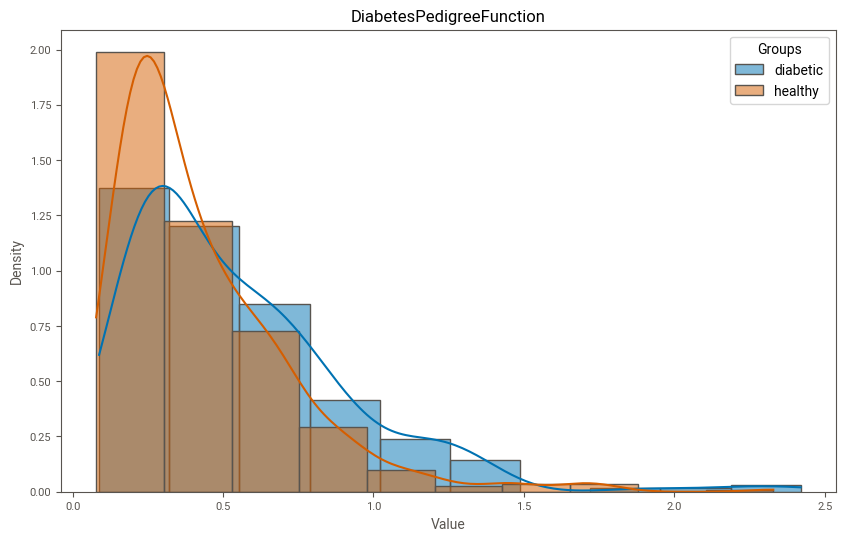

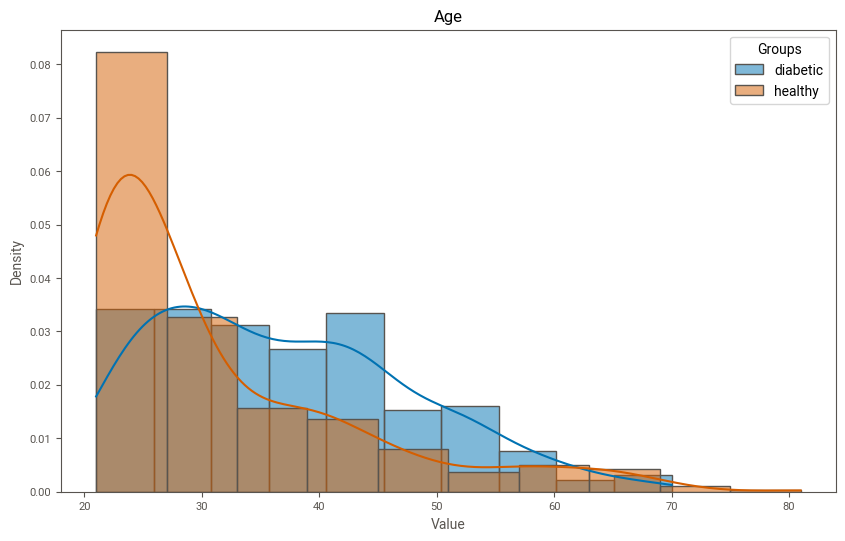

In [24]:
def plot_distribution(data_select, size_bin):
    # Input Validation
    if size_bin <= 0:
        raise ValueError("size_bin must be a positive integer greater than zero.")

    # Replace inf values with NaN globally in the dataframe
    cleaned_data = data.replace([np.inf, -np.inf], np.nan)
    
    # Filter out invalid data (zeros or NaNs)
    diabetic_data = cleaned_data[(cleaned_data['Outcome'] == 1) & (cleaned_data[data_select] > 0)].dropna(subset=[data_select])  # Diabetic group
    healthy_data = cleaned_data[(cleaned_data['Outcome'] == 0) & (cleaned_data[data_select] > 0)].dropna(subset=[data_select])  # Healthy group

    diabetic_values = diabetic_data[data_select]
    healthy_values = healthy_data[data_select]
    
    group_labels = ['diabetic', 'healthy']
    # Use color blind friendly colors
    colors = ['#0072B2', '#D55E00']

    # Suppress the FutureWarning related to the deprecated option
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)

        # Create histograms with KDE
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot histogram for diabetic group
        sns.histplot(diabetic_values, bins=size_bin, color=colors[0], kde=True, label=group_labels[0], ax=ax, stat="density", alpha=0.5)

        # Plot histogram for healthy group
        sns.histplot(healthy_values, bins=size_bin, color=colors[1], kde=True, label=group_labels[1], ax=ax, stat="density", alpha=0.5)

        ax.set_title(data_select)
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend(title="Groups")

        plt.show()
        
# List of continuous features
continuous_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Plot distribution for all continuous features
for feature in continuous_features:
    plot_distribution(feature, 10)

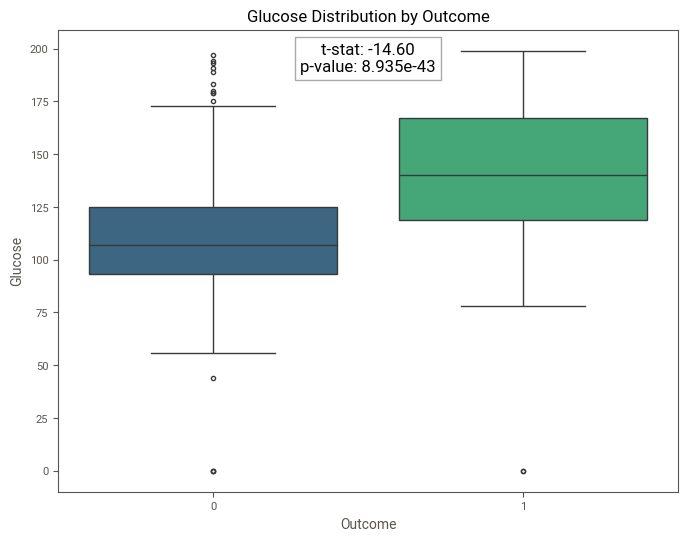

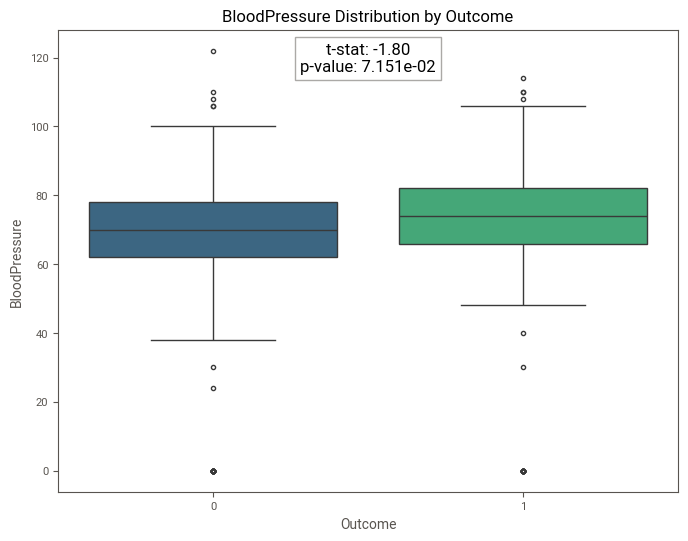

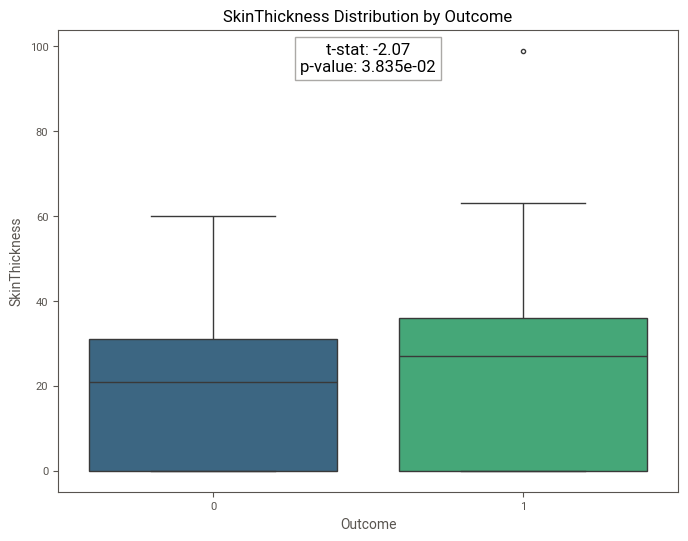

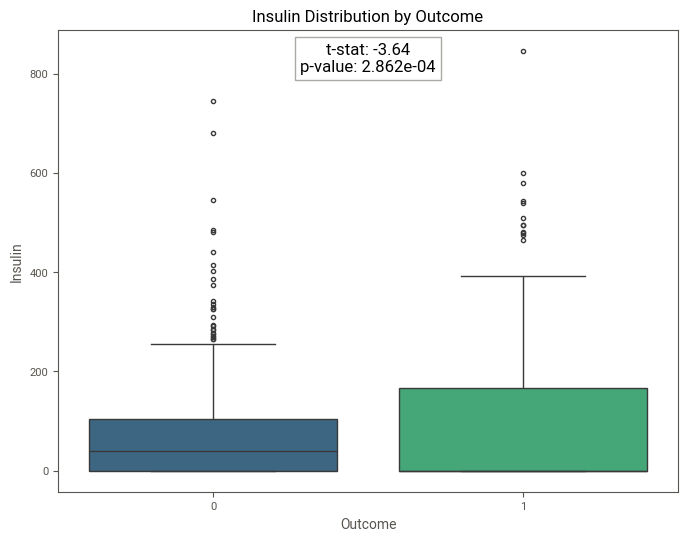

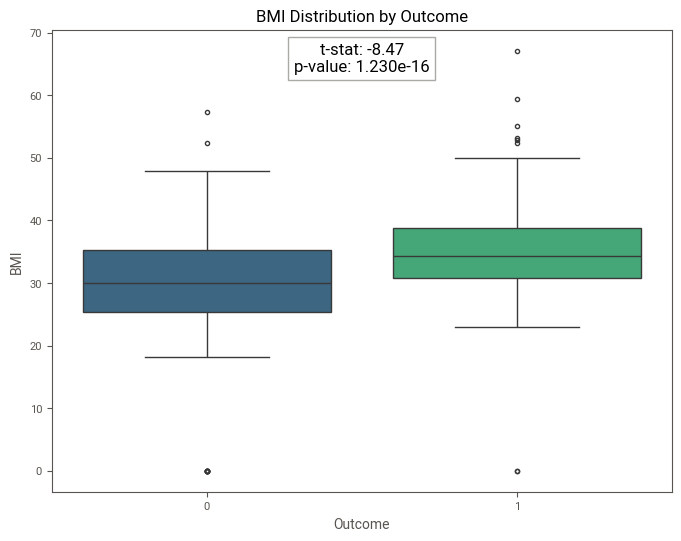

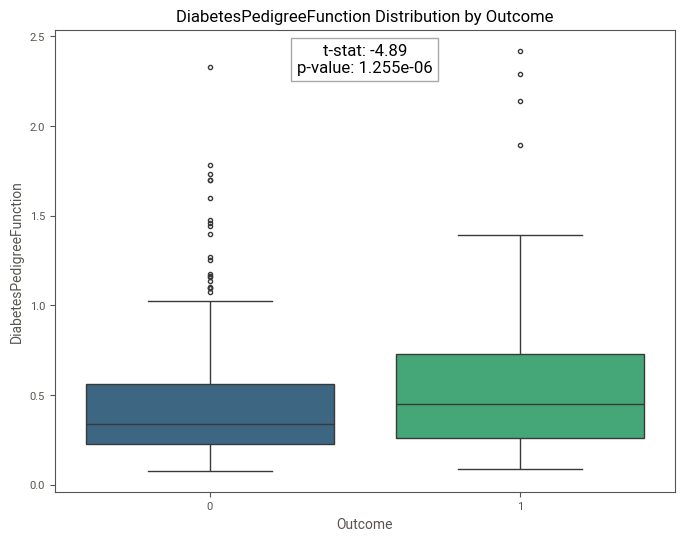

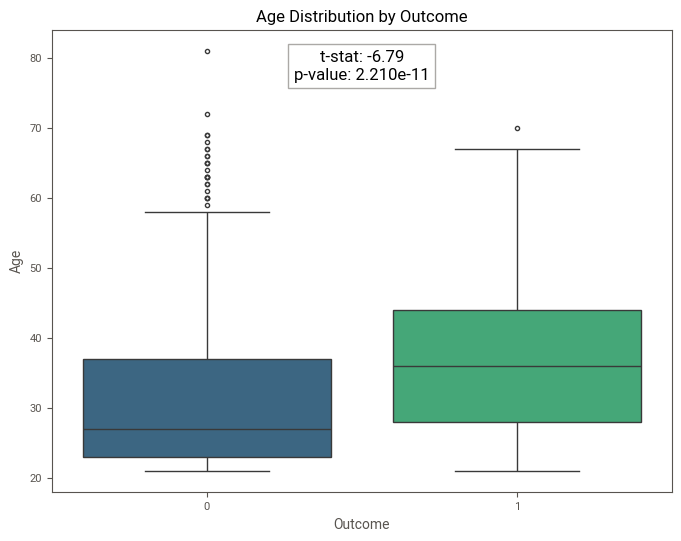

In [25]:
# Boxplots to compare continuous features for different Outcome groups with statistical results
continuous_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

for feature in continuous_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Outcome', y=feature, data=data, palette='viridis')
    plt.title(f'{feature} Distribution by Outcome')
    plt.xlabel('Outcome')
    plt.ylabel(feature)
    
    # Perform t-test between the Outcome groups
    group0 = data[data['Outcome'] == 0][feature]
    group1 = data[data['Outcome'] == 1][feature]
    t_stat, p_value = ttest_ind(group0, group1)
    
    # Annotate the plot with t-test results
    plt.text(0.5, max(data[feature]) * 0.95, f't-stat: {t_stat:.2f}\np-value: {p_value:.3e}', 
             horizontalalignment='center', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

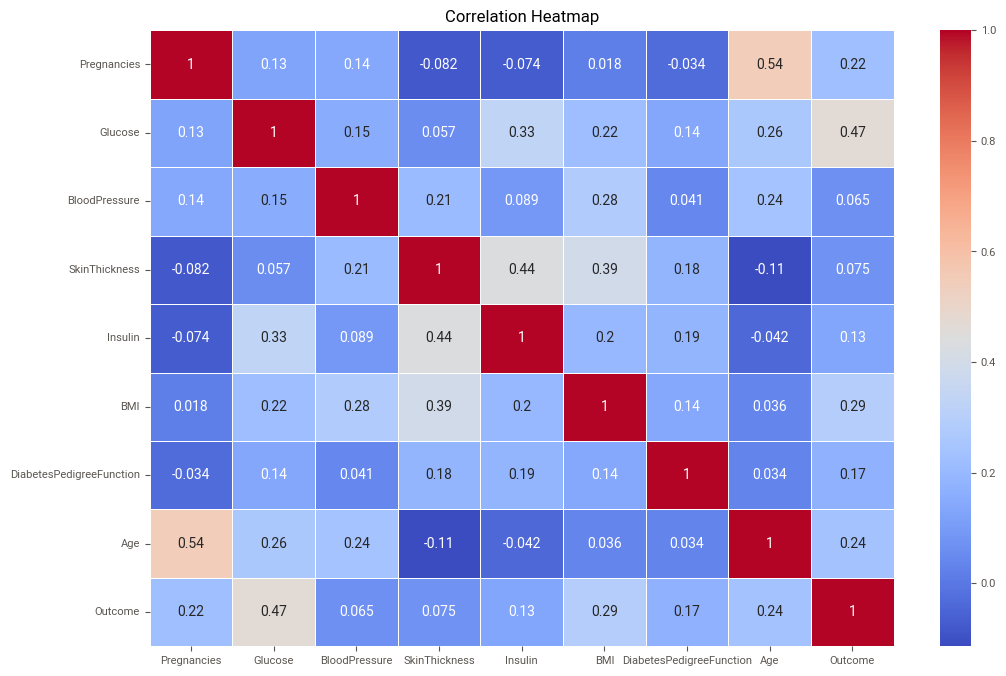

In [26]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [27]:
# Displaying correlations with Outcome
target_corr = data.corr()['Outcome'].sort_values(ascending=False)
print('Correlations with Outcome:\n')
print(target_corr)

Correlations with Outcome:

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


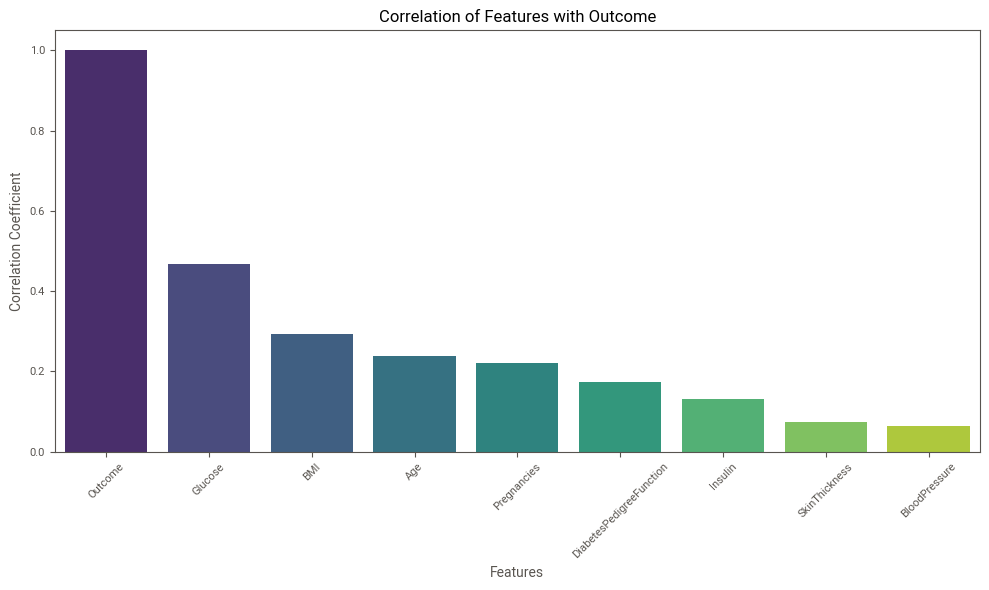

In [28]:
# Create visualizations to highlight key insights

plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.index, y=target_corr.values, palette='viridis')
plt.xticks(rotation=45)
plt.title('Correlation of Features with Outcome')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

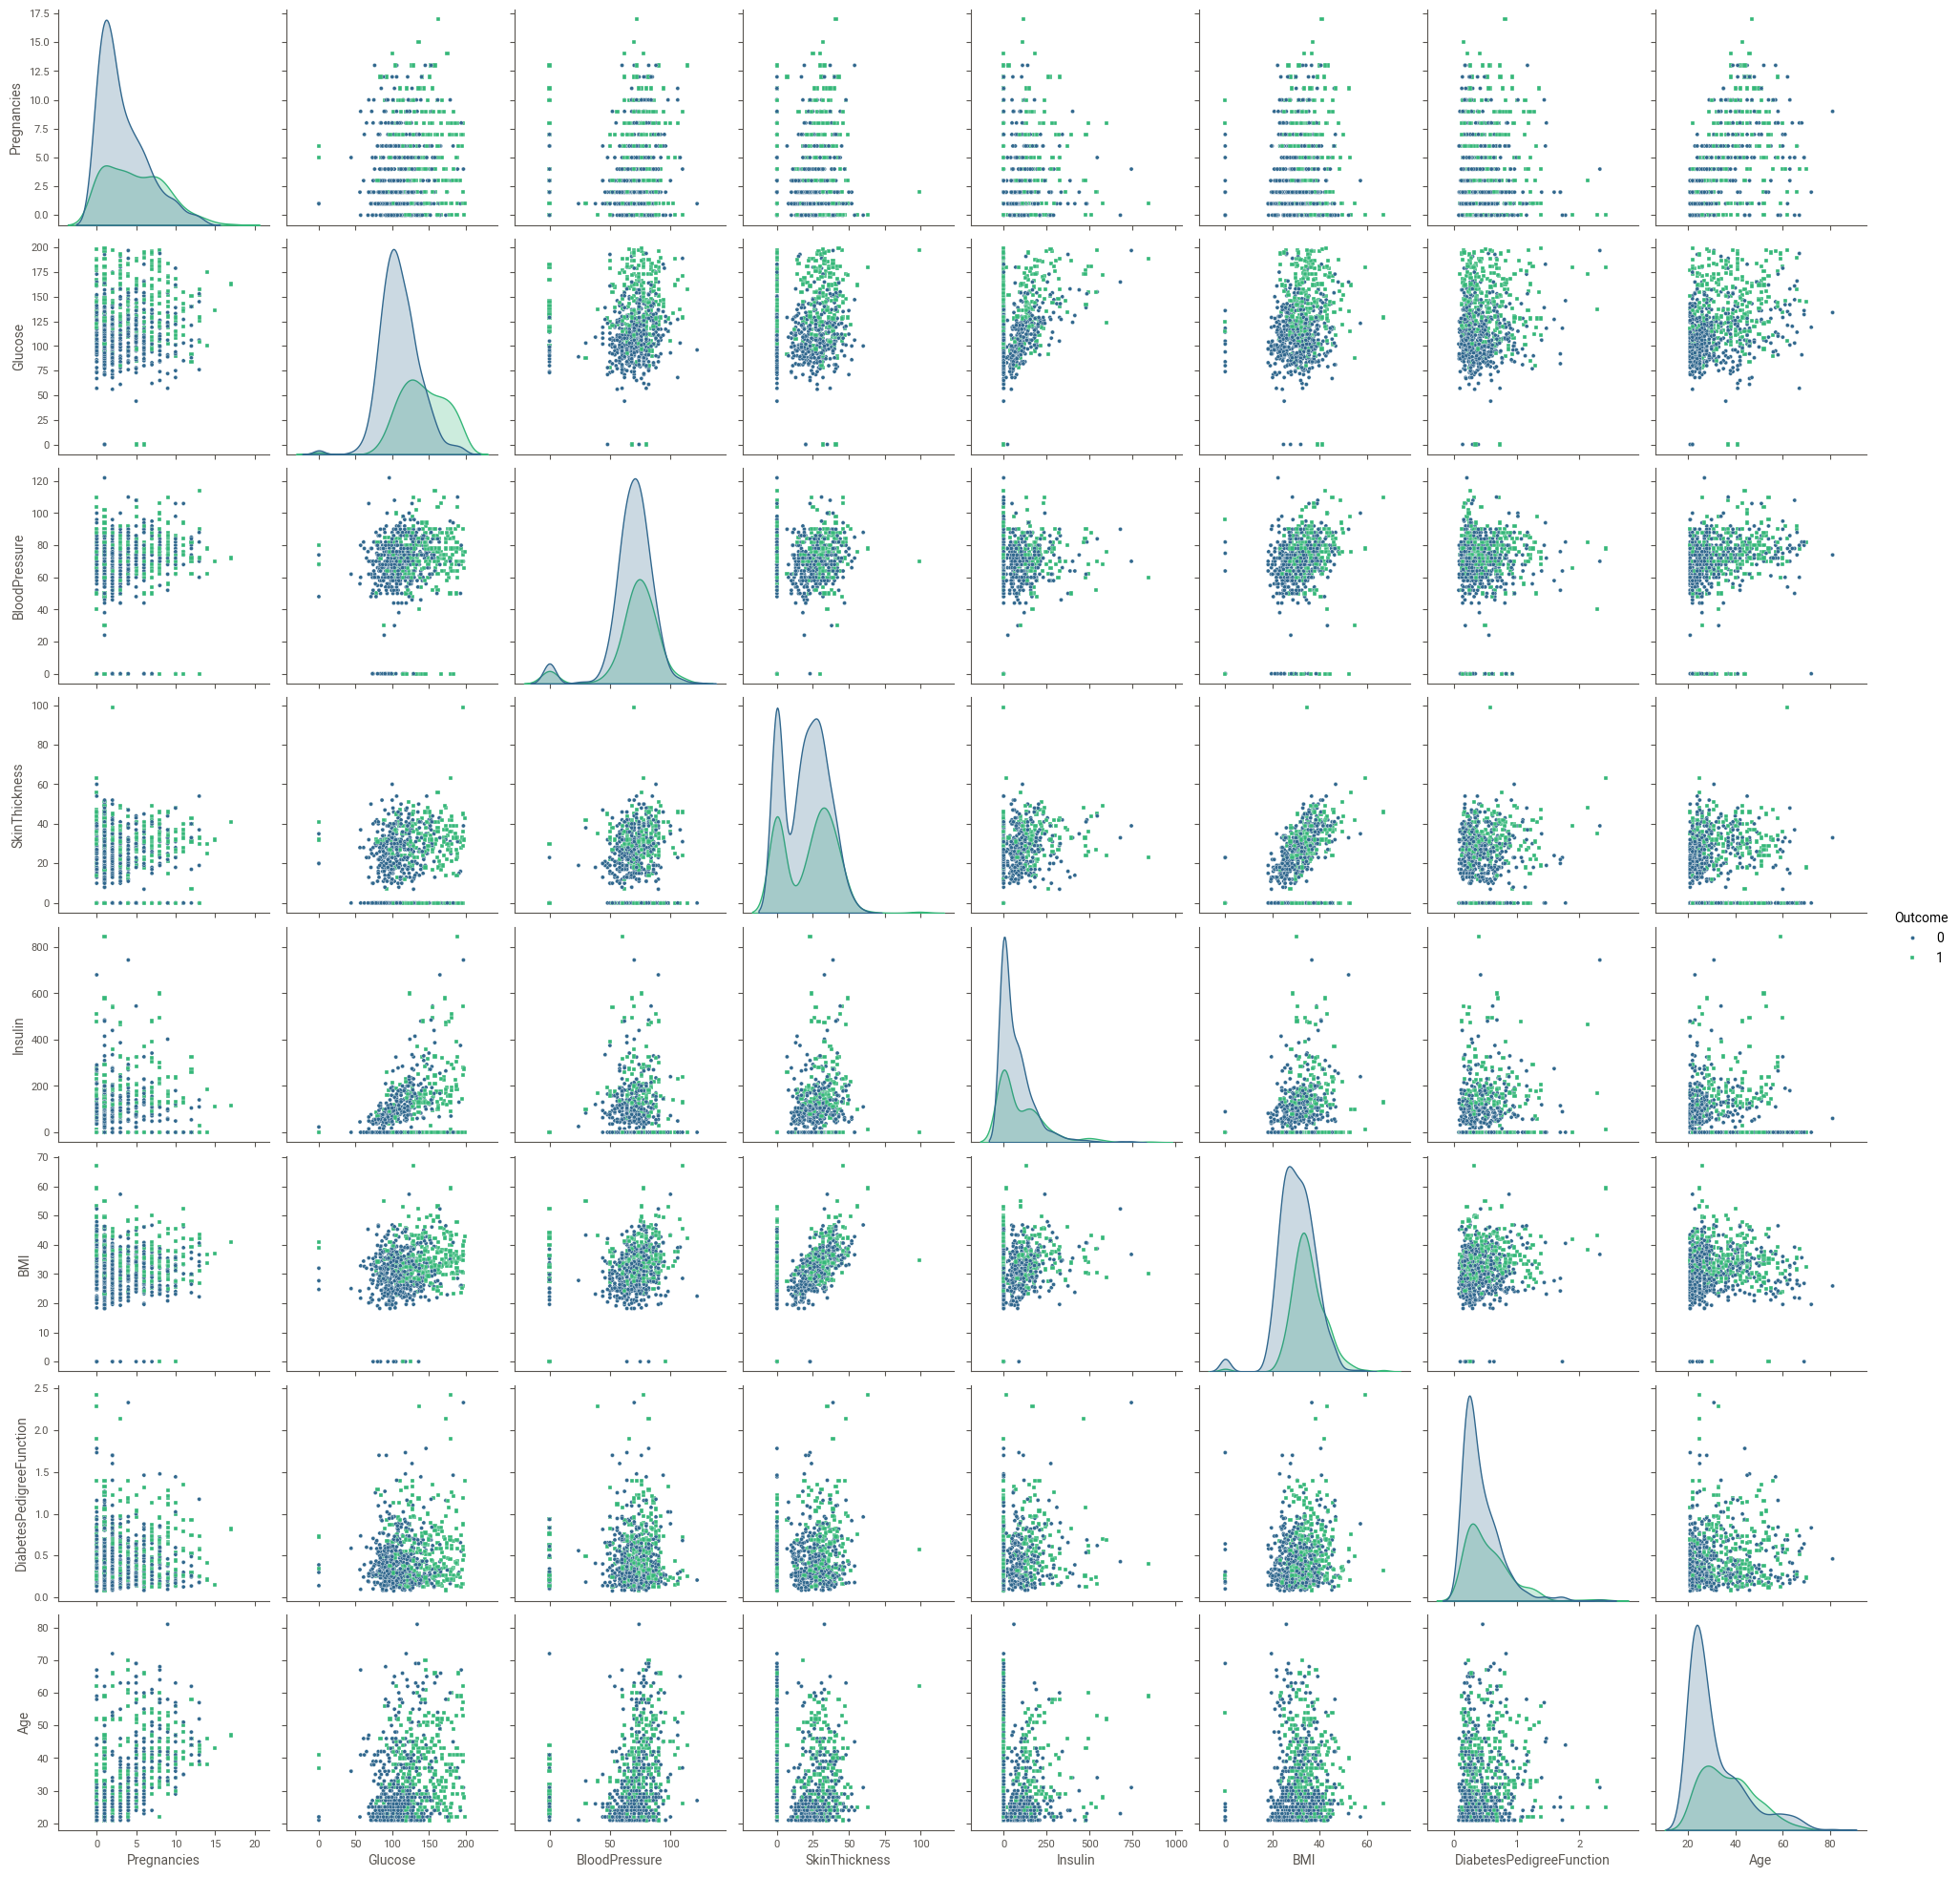

In [29]:
#  Pairplot to observe pairwise relationships between features

sns.pairplot(data, hue='Outcome', palette='viridis', diag_kind='kde', markers=['o', 's'])
plt.show()

# Feature engineering

In [30]:
# Split the data into training and testing datasets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [31]:
train_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
60,2,84,0,0,0,0.0,0.304,21,0
618,9,112,82,24,0,28.2,1.282,50,1
346,1,139,46,19,83,28.7,0.654,22,0
294,0,161,50,0,0,21.9,0.254,65,0
231,6,134,80,37,370,46.2,0.238,46,1


In [32]:
test_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
668,6,98,58,33,190,34.0,0.430,43,0
324,2,112,75,32,0,35.7,0.148,21,0
624,2,108,64,0,0,30.8,0.158,21,0
690,8,107,80,0,0,24.6,0.856,34,0
473,7,136,90,0,0,29.9,0.210,50,0


In [33]:
print(train_data.info())
print("\nShape of train_data:", train_data.shape)
print("\nFirst few rows of 'age' column:")
print(train_data['Age'].head())

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 60 to 102
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    int64  
 1   Glucose                   614 non-null    int64  
 2   BloodPressure             614 non-null    int64  
 3   SkinThickness             614 non-null    int64  
 4   Insulin                   614 non-null    int64  
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    int64  
 8   Outcome                   614 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 48.0 KB
None

Shape of train_data: (614, 9)

First few rows of 'age' column:
60     21
618    50
346    22
294    65
231    46
Name: Age, dtype: int64


In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats

def feature_engineering(df):
    # Create a copy of the dataframe to avoid modifying the original
    df = df.copy()
    
    # 1. Binning Age to create categorical age bins
    df['age_bin'] = pd.cut(df['Age'], bins=[0, 30, 45, 60, df['Age'].max() + 1], 
                           labels=['Young', 'Middle', 'Senior', 'Elderly'], include_lowest=True)
    
    # 2. Handle skewness with log transformation
    skewed_features = ['Pregnancies', 'Insulin', 'DiabetesPedigreeFunction']
    for feature in skewed_features:
        df[f'{feature}_log'] = np.log1p(df[feature])
    
    # 3. Handle outliers using IQR method
    def handle_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return np.clip(column, lower_bound, upper_bound)

    outlier_features = ['Glucose', 'BloodPressure', 'Insulin', 'BMI']
    for feature in outlier_features:
        df[feature] = handle_outliers(df[feature])
    
    # 4. Feature interactions (limited to most important)
    df['glucose_bmi'] = df['Glucose'] * df['BMI']
    
    # 5. Standardization for numerical features
    scaler = StandardScaler()
    numerical_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
    df[numerical_features] = scaler.fit_transform(df[numerical_features])
    
    # 6. One-hot encode the age bin
    df = pd.get_dummies(df, columns=['age_bin'], prefix='age')
    
    return df

# Sample dataset loading
# Assuming your dataset is loaded into a dataframe named 'data'
try:
    # Apply the feature engineering function to your data
    data_transformed = feature_engineering(data)
    print("Feature engineering completed successfully.")
    print("\nTransformed data info:")
    print(data_transformed.info())
    print("\nFirst few rows of transformed data:")
    print(data_transformed.head())
except Exception as e:
    print(f"Error in feature engineering: {str(e)}")

# Split the data into training and testing sets
try:
    X = data_transformed.drop('Outcome', axis=1)
    y = data_transformed['Outcome']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("Shape of training data:", X_train.shape)
    print("Shape of testing data:", X_test.shape)
except Exception as e:
    print(f"Error in splitting data: {str(e)}")

Feature engineering completed successfully.

Transformed data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Pregnancies                   768 non-null    float64
 1   Glucose                       768 non-null    float64
 2   BloodPressure                 768 non-null    float64
 3   SkinThickness                 768 non-null    int64  
 4   Insulin                       768 non-null    float64
 5   BMI                           768 non-null    float64
 6   DiabetesPedigreeFunction      768 non-null    float64
 7   Age                           768 non-null    float64
 8   Outcome                       768 non-null    int64  
 9   Pregnancies_log               768 non-null    float64
 10  Insulin_log                   768 non-null    float64
 11  DiabetesPedigreeFunction_log  768 non-null    float64
 

# Explore best models

In [35]:
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

In [36]:
# Creating a preprocessing pipeline
categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_preprocessor, numerical_cols),
        ('cat', categorical_preprocessor, categorical_cols)
    ])

In [37]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'SGDClassifier': SGDClassifier(max_iter=1000, random_state=42),
    'RidgeClassifier': RidgeClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(silent=True, random_state=42)
}

# Stratified K-Fold for balanced sampling
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training models and evaluating performance using ROC AUC score
scores = {}
for name, model in models.items():
    # For AUC scoring, SVC needs `probability=True`
    if name == 'SVC':
        model.probability = True
        
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='roc_auc')
    scores[name] = cv_scores
    print(f"{name}: {cv_scores.mean()} ± {cv_scores.std()}")

RandomForest: 0.8307432443979602 ± 0.023169172611640965
LogisticRegression: 0.8345150595408993 ± 0.025611883983113606
SVC: 0.8309278399846877 ± 0.03017569169257991
SGDClassifier: 0.7197241704606047 ± 0.07275951579008177
RidgeClassifier: 0.8361584157062193 ± 0.024737047765743536


/home/matt/miniforge3/envs/pimaIndianDataAutoML/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/matt/miniforge3/envs/pimaIndianDataAutoML/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/matt/miniforge3/envs/pimaIndianDataAutoML/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:21:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/matt/miniforge3/envs/pimaIndianDataAutoML/lib/python

XGBoost: 0.8073179251603024 ± 0.021752221241749945
[LightGBM] [Info] Number of positive: 171, number of negative: 320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 984
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348269 -> initscore=-0.626657
[LightGBM] [Info] Start training from score -0.626657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

/tmp/ipykernel_762778/4193621285.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(sorted_scores.values(), labels=sorted_scores.keys())


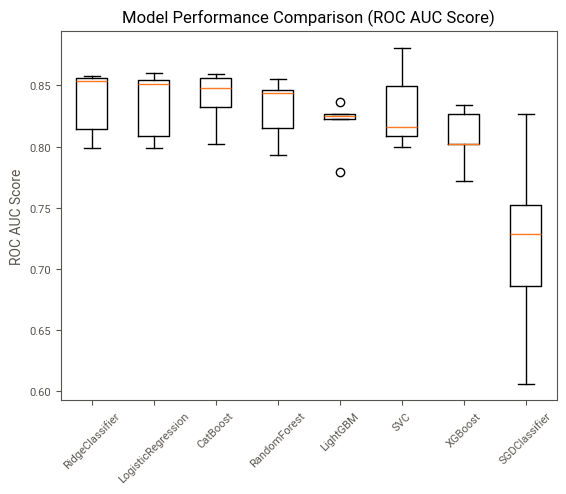

In [38]:
# Plotting model performances for ROC AUC
sorted_scores = {k: v for k, v in sorted(scores.items(), key=lambda item: -np.median(item[1]))}

plt.boxplot(sorted_scores.values(), labels=sorted_scores.keys())
plt.xticks(rotation=45)
plt.title('Model Performance Comparison (ROC AUC Score)')
plt.ylabel('ROC AUC Score')
plt.show()

# Train ensemble model

In [41]:
# Define StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define objective functions for each model
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1e-2, 100, log=True)
    }
    model = CatBoostClassifier(**params, silent=True, random_state=42)
    return evaluate_model(model)

def objective_log_reg(trial):
    params = {
        'C': trial.suggest_float('C', 1e-5, 1e2, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': 'liblinear',  # 'liblinear' works well with both L1 and L2 regularization
        'max_iter': 1000
    }
    model = LogisticRegression(**params, random_state=42)
    return evaluate_model(model)

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    model = RandomForestClassifier(**params, random_state=42)
    return evaluate_model(model)

def evaluate_model(model):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    try:
        scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='roc_auc')
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return float('-inf')

# Configure logging
logging.basicConfig(filename='optuna_log.txt', level=logging.INFO, format='%(asctime)s - %(message)s')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run Optuna optimization for each model
def optimize_model(objective, n_trials):
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials, catch=(Exception,))
    return study.best_params, study.best_value

print("Optimizing CatBoost...")
best_catboost_params, best_catboost_score = optimize_model(objective_catboost, N_TRIALS)

print("Optimizing Logistic Regression...")
best_log_reg_params, best_log_reg_score = optimize_model(objective_log_reg, N_TRIALS)

print("Optimizing Random Forest...")
best_rf_params, best_rf_score = optimize_model(objective_rf, N_TRIALS)

# Initialize models with best parameters
best_catboost = CatBoostClassifier(**best_catboost_params, random_state=42, silent=True)
best_log_reg = LogisticRegression(**best_log_reg_params, random_state=42)
best_rf = RandomForestClassifier(**best_rf_params, random_state=42)

# Create voting classifier
voting_clf = VotingClassifier(estimators=[
    ('catboost', best_catboost),
    ('log_reg', best_log_reg),
    ('rf', best_rf)
], voting='soft')

# Final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', voting_clf)])

# Train and evaluate the ensemble model
pipeline.fit(X_train, y_train)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
ensemble_auc = roc_auc_score(y_test, y_pred_proba)

print("\nBest Model Parameters:")
print("CatBoost:", best_catboost_params)
print("Logistic Regression:", best_log_reg_params)
print("Random Forest:", best_rf_params)

print("\nBest Model Scores:")
print("CatBoost AUC:", best_catboost_score)
print("Logistic Regression AUC:", best_log_reg_score)
print("Random Forest AUC:", best_rf_score)
print("Ensemble Model Test AUC:", ensemble_auc)

Optimizing CatBoost...


[W 2025-03-09 17:28:29,840] Trial 9 failed with parameters: {'iterations': 104, 'depth': 9, 'learning_rate': 0.025924756604751596, 'l2_leaf_reg': 1.5382308040278996, 'bagging_temperature': 0.7712703466859457, 'random_strength': 0.7413724726891696, 'border_count': 112, 'scale_pos_weight': 0.029072088906598452} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/home/matt/miniforge3/envs/pimaIndianDataAutoML/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_762778/2679783409.py", line 17, in objective_catboost
    return evaluate_model(model)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_762778/2679783409.py", line 43, in evaluate_model
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='roc_auc')
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/h

KeyboardInterrupt: 

In [ ]:
# Step 1: Train the model on the full training dataset
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Pregnancies_log',
       'Insulin_log', 'DiabetesPedigreeFunction_log', 'glucose_bmi'...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('classifier',
                 VotingClassifier(estimators=[('catboost',
                                               <catboost.core.CatBoostClassifier object at 0x7821a1fb3910>),
                                              ('log_reg',
                                               LogisticRegression(C=0.03874839839414661,
                                                                  random_state=42)),
                                              ('rf',
                                               RandomForestClassifier(max_depth=14,
                                                                      max_features='log2',
                                                                      min_samples_split=20,
                                                                      n_estimators=981,
                                                                      random_state=42))],
                                  voting='soft'))])

In [ ]:
# Step 2: Predictions on the test dataset
y_test_pred = pipeline.predict_proba(X_test)

In [ ]:
# Calculating Metrics
auc = roc_auc_score(y_test, y_pred_proba) 
print("AUC Score:", auc)

AUC Score: 0.8198347107438017


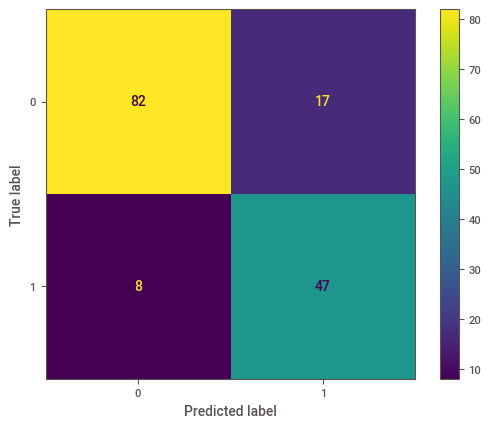

In [ ]:
# Confusion Matrix
y_test_pred = pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

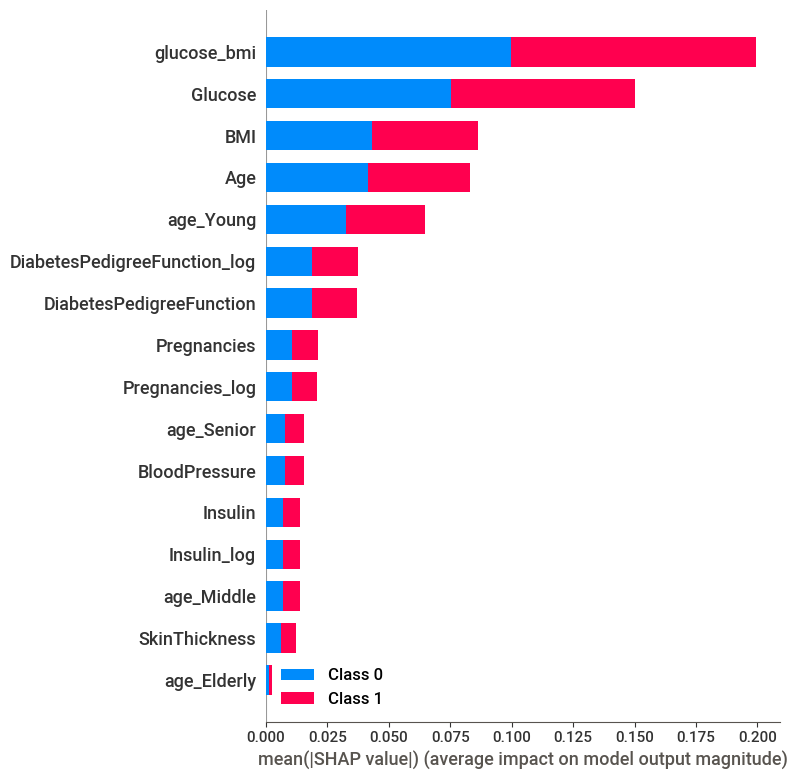

In [ ]:
# Fit the RandomForest model before using SHAP for feature importance
best_rf.fit(X_train, y_train)

# Convert X_train to numeric array
X_train_numeric = np.array(X_train)
X_test_numeric = np.array(X_test)

# Create Feature Importance using SHAP for RandomForest only
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test_numeric)

# Plot Feature Importances
shap.summary_plot(shap_values, X_test_numeric, feature_names=X_train.columns, plot_type="bar")

# Train Autogluon model

In [ ]:
# AutoGluon Model Training for Outcome Prediction
train_data = X_train.copy()
train_data['Outcome'] = y_train  # Add target column for AutoGluon

In [ ]:
test_data = X_test.copy()
test_data['Outcome'] = y_test  # Add target column for AutoGluon evaluation

In [ ]:
target = 'Outcome'

In [ ]:
# Train AutoGluon model with the desired adjustments
predictor = TabularPredictor(label=target, eval_metric='roc_auc').fit(
    train_data,
    presets='best_quality',  # Using the best quality preset for higher accuracy
    time_limit=TIME_LIMIT,  # You can set a time limit to control how long the training runs (in seconds)
    num_bag_folds=5,  # Enable ensembling by using bagging with 8 folds
    num_stack_levels=1,  # Enable stacking to further improve model performance
    ag_args_fit={'use_gpu': False},  # Set to True to use GPU for model training
    verbosity=0  # Set verbosity level to suppress too much logging output (0: most silent, 4: most detailed)
)

No path specified. Models will be saved in: "AutogluonModels/ag-20241013_162512"
Failed to use ray for memory safe fits. Falling back to normal fit. Error: ValueError('ray==2.24.0 detected. 2.10.0 <= ray < 2.11.0 is required. You can use pip to install certain version of ray `pip install ray==2.10.0` ')


In [ ]:
# Review the leaderboard of different models trained by AutoGluon
leaderboard = predictor.leaderboard(silent=True)
leaderboard

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.867479,roc_auc,4.798512,6638.136904,0.000816,0.217832,2,True,45
1,CatBoost_r50_BAG_L1,0.853559,roc_auc,0.009388,3.909702,0.009388,3.909702,1,True,33
2,NeuralNetTorch_r14_BAG_L1,0.850878,roc_auc,0.221806,321.029526,0.221806,321.029526,1,True,39
3,NeuralNetFastAI_r143_BAG_L1,0.850702,roc_auc,1.434752,1493.647383,1.434752,1493.647383,1,True,41
4,CatBoost_r69_BAG_L1,0.850269,roc_auc,0.008301,3.514910,0.008301,3.514910,1,True,37
5,NeuralNetTorch_r22_BAG_L1,0.850058,roc_auc,0.351994,1247.975091,0.351994,1247.975091,1,True,20
6,CatBoost_r177_BAG_L1,0.849379,roc_auc,0.008314,3.570244,0.008314,3.570244,1,True,14
7,CatBoost_BAG_L1,0.849086,roc_auc,0.008298,4.611342,0.008298,4.611342,1,True,7
8,NeuralNetFastAI_r156_BAG_L1,0.848641,roc_auc,0.598011,309.805506,0.598011,309.805506,1,True,43
9,LightGBM_r96_BAG_L1,0.848536,roc_auc,0.015586,5.065251,0.015586,5.065251,1,True,19


In [ ]:
# Feature Importance from AutoGluon
feature_importance = predictor.feature_importance(train_data).reset_index()
print("AutoGluon Feature Importance:")
feature_importance

AutoGluon Feature Importance:


,index,importance,stddev,p_value,n,p99_high,p99_low
0,glucose_bmi,0.066360,0.011046,8.883117e-05,5,0.089105,0.043615
1,Glucose,0.044192,0.006092,4.226881e-05,5,0.056737,0.031648
2,BMI,0.021844,0.003674,9.250037e-05,5,0.029409,0.014280
3,BloodPressure,0.020945,0.002556,2.610354e-05,5,0.026209,0.015682
4,Age,0.015492,0.002883,1.374841e-04,5,0.021428,0.009556
5,DiabetesPedigreeFunction_log,0.014298,0.001990,4.390848e-05,5,0.018395,0.010200
6,Insulin_log,0.012242,0.001750,4.875314e-05,5,0.015845,0.008639
7,Insulin,0.011502,0.001854,7.823509e-05,5,0.015319,0.007685
8,DiabetesPedigreeFunction,0.010385,0.001076,1.363962e-05,5,0.012601,0.008169
9,age_Young,0.008556,0.002500,7.830092e-04,5,0.013703,0.003409


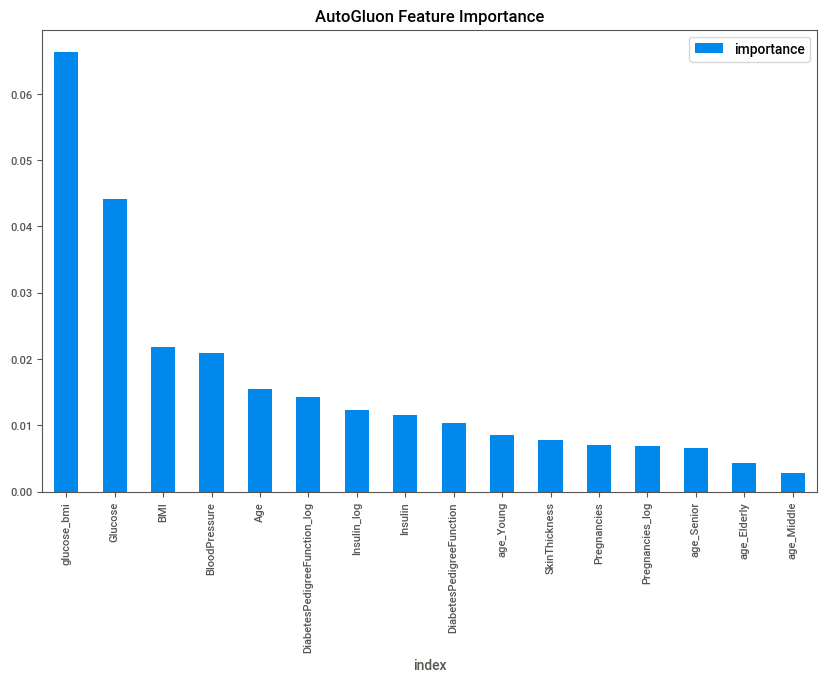

In [ ]:
# Plot Feature Importance
feature_importance.plot(kind='bar', x='index', y='importance', title='AutoGluon Feature Importance', figsize=(10, 6))
plt.show()

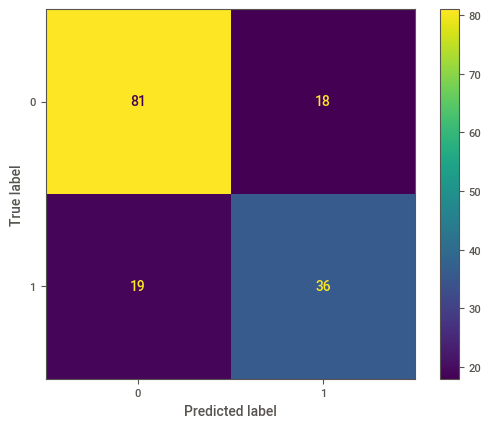

In [ ]:
# Confusion Matrix for AutoGluon
y_test_pred_autogluon = predictor.predict(test_data)
conf_matrix_autogluon = confusion_matrix(y_test, y_test_pred_autogluon)
ConfusionMatrixDisplay(conf_matrix_autogluon).plot()
plt.show()